In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import PIL
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
import numpy as np
from PIL import Image
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.models import load_model
from imutils import paths
from IPython.display import clear_output, display
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import load_boston, load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers
from keras.regularizers import l1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

In [0]:
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return np.array([skimage.color.rgb2gray(img) for img in X])

In [0]:
class HogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
        try:
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

**Pipeline for Grid Search**

In [0]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    ) 
    fitted_model = gs.fit(X_train_data, y_train_data)
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    return fitted_model, pred

**Model Function**

In [0]:
def build_MLP(classes, activation = 'relu', dropout_rate = 0.2, learning_rate=1e-3, epochs=100):
  model = Sequential()
  model.add(Dense(512, activation='linear', activity_regularizer=l1(0.001)))
  model.add(Activation('relu'))
  model.add(Dense(512))
  model.add(Activation(activation))
  model.add(Dense(512))
  model.add(Activation('linear'))
  model.add(Dense(512))
  model.add(Activation(activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(classes))
  model.add(Activation("softmax"))
  model.compile(loss="categorical_crossentropy", optimizer='Adam', metrics=["accuracy"])
  return model

**Getting Files and Label Names as Reshaped Array Function**

In [0]:
def get_image_list_from_folder(imageFolderPath, dim1, dim2):
  IMAGE_DIMS = (dim1, dim2, 3)
  data = []
  labels = []
  counter=0
  imagePaths=glob.glob(imageFolderPath+'**/*.jpg', recursive=True)
  # loop over the input images
  for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    try:
      counter=counter+1
      
      #image = Image.open(imagePath).resize((IMAGE_DIMS[1],IMAGE_DIMS[0]))
      #image = np.array(image)
      image = cv2.imread(imagePath)
      image_norm = cv2.resize(image, (dim2, dim1))
      image_norm = img_to_array(image_norm)
      
      #Preproccessing
      temp_img= cv2.resize(image, (dim2, dim1))
      temp_img= cv2.GaussianBlur(temp_img, (5, 5), 0)
      gray = cv2.cvtColor(temp_img, cv2.COLOR_RGB2GRAY)
      ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
      kernel = np.ones((3, 3), np.uint8)
      opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
      sure_bg = cv2.dilate(opening, kernel, iterations=3)
      dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
      ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
      sure_fg = np.uint8(sure_fg)
      unknown = cv2.subtract(sure_bg, sure_fg)
      ret, markers = cv2.connectedComponents(sure_fg)
      markers = markers + 1
      markers[unknown == 255] = 0
      markers = cv2.watershed(temp_img, markers)
      temp_img[markers == -1] = [255, 0, 0]
      data.append(temp_img)

      data.append(image_norm)

      # extract the class label from the image path and update the
      # labels list
      label = imagePath.split(os.path.sep)[-2]
      labels.append(label)
      labels.append(label)
    except:
      print("A corrupted file.")
  return data, labels

**Address of the Base Image Path**

In [0]:
base_folder_address=cards_folder_address=os.getcwd()+"/drive/My Drive/project/Project-Files/Dataset_2/"

**Getting the Dataset and Labels & Also it contains the Processed Images**

In [0]:
#Specify the desired dimensions for the images
IMAGE_DIMS = (100, 100, 3)
#Specify the folder that contains your images
data, labels=get_image_list_from_folder(base_folder_address, IMAGE_DIMS[1], IMAGE_DIMS[0])
print("Total image count with the processed ones:",len(data))

Total image count with the processed ones: 3732


In [0]:
data = np.array(data, dtype="float")

**Scaling the Dataset**

In [0]:
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(8, 8),
    cells_per_block=(2,2),
    orientations=9,
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
data = grayify.fit_transform(data)
data = hogify.fit_transform(data)
data = scalify.fit_transform(data)
print("Your data matrix has the size of {:.2f} MB without the augmented images.".format(
data.nbytes / (1024 * 1000.0)))

Your data matrix has the size of 127.00 MB without the augmented images.


**Binarizing the Labels**

In [0]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("You have",len(lb.classes_),"classes at your data.")

You have 9 classes at your data.


**Training and Test Split**

In [0]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.15, random_state=42)
(trainX, validationX, trainY, validationY) = train_test_split(trainX, trainY, test_size=0.15, random_state=42)
print("Your Train Data size is:",len(trainX))
print("Your Validation Data size is:",len(validationX))
print("Your Test Data size is:",len(testX))

Your Train Data size is: 2696
Your Validation Data size is: 476
Your Test Data size is: 560


**Data Augmentation**

In [0]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

# **Grid Search**

In [0]:
param_grid = {
              'width': [IMAGE_DIMS[1]],
              'height': [IMAGE_DIMS[0]],
              'depth': [IMAGE_DIMS[2]],
              'classes': [len(lb.classes_)],
              'epochs':[10],
              'dropout_rate' :[0.2],
              'activation' :['relu']
             }

model = KerasClassifier(build_fn = build_MLP, verbose=0)
model, pred = algorithm_pipeline(trainX, testX, trainY, testY, model, param_grid, cv=3, scoring_fit='neg_log_loss')

print("Best Score:",model.best_score_)
print("Best Parameters:",model.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.5min finished


-5.737121735912571
{'activation': 'relu', 'classes': 9, 'depth': 3, 'dropout_rate': 0.2, 'epochs': 1, 'height': 100, 'width': 100}


# **Creating a Model with Validation**

In [0]:
EPOCHS = 50
INIT_LR = 1e-6
BS = 32

#Compiling the model
model = build_MLP(classes=len(lb.classes_))


#Training the Model
print("Training the model:")
H = model.fit( x=trainX, y=trainY, validation_data=(validationX, validationY), epochs=EPOCHS, verbose=1)

Training the model:
Train on 2696 samples, validate on 476 samples
Epoch 1/50
2696/2696 [==============================] - 4s 1ms/step - loss: 15.2180 - accuracy: 0.4889 - val_loss: 13.5236 - val_accuracy: 0.6050
Epoch 2/50
2696/2696 [==============================] - 4s 1ms/step - loss: 12.0838 - accuracy: 0.6962 - val_loss: 12.5931 - val_accuracy: 0.5735
Epoch 3/50
2696/2696 [==============================] - 4s 1ms/step - loss: 11.0261 - accuracy: 0.7767 - val_loss: 12.1328 - val_accuracy: 0.6303
Epoch 4/50
2696/2696 [==============================] - 4s 1ms/step - loss: 10.2555 - accuracy: 0.8297 - val_loss: 11.5941 - val_accuracy: 0.6492
Epoch 5/50
2696/2696 [==============================] - 4s 1ms/step - loss: 9.6613 - accuracy: 0.8505 - val_loss: 11.6112 - val_accuracy: 0.5966
Epoch 6/50
2696/2696 [==============================] - 4s 1ms/step - loss: 9.3586 - accuracy: 0.8780 - val_loss: 10.9870 - val_accuracy: 0.6639
Epoch 7/50
2696/2696 [==============================] - 4s 

# **Get Loss Plots**

Text(0.5, 1.0, 'Accuracy Curves')

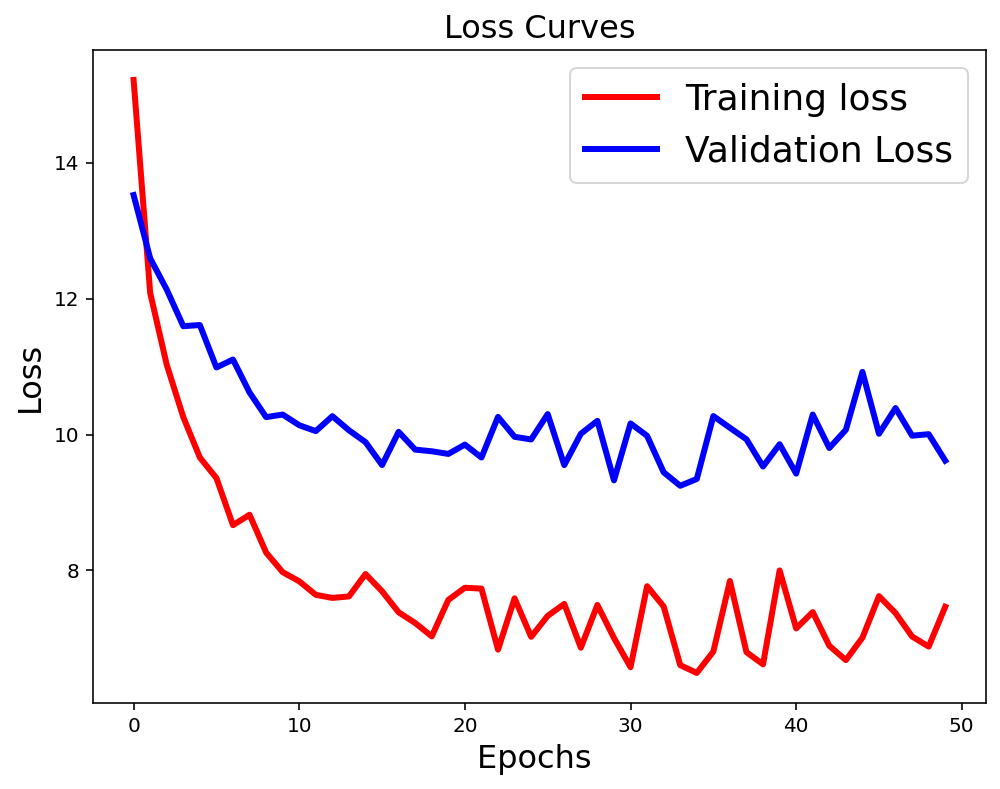

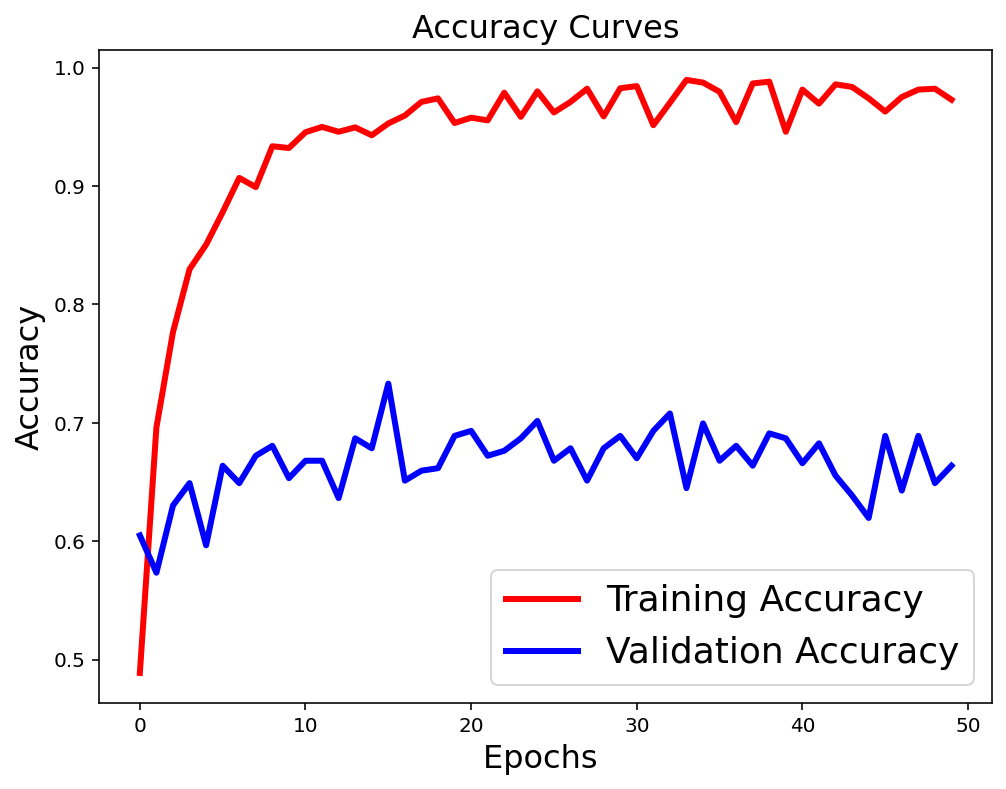

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

history=H
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

# **Evaluation with the Test Data**

In [0]:
results = model.evaluate(testX, testY, batch_size=32)
print("Loss",results[0])
print("Accuracy:",results[1])

560/560 [==============================] - 0s 208us/step
Loss 9.770337731497628
Accuracy: 0.6535714268684387


# **Saving the Model**

Please be sure that you are not overwriting on your other models.

In [0]:
model_tmp=model
try:
  model_tmp.save(os.getcwd()+"/drive/My Drive/project/Project-Files/"+"model_dataset_2_marked_50_epoch_MLP_hough_transform_good.h5")
  print("Saved model to disk")
except:
  print("Problem while saving the model.")

Saved model to disk


# **Loading a Model**

In [0]:
model = tf.keras.models.load_model(os.getcwd()+"/drive/My Drive/project/Project-Files/"+"model_dataset_2_marked_50_epoch_MLP.h5") # maske tespiti modeli

# **Try a Single Image**

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Specify the single image address
img_address=os.getcwd()+"/drive/My Drive/project/Project-Files/Images/pen/13.jpg";


image_s = cv2.imread(img_address)
image_s = cv2.resize(image_s, (100, 100))
image_s = img_to_array(image_s)
image_s = np.array(image_s, dtype="float") / 255.0

image_s = grayify.fit_transform(image_s)
image_s = hogify.fit_transform(image_s)
image_s = scalify.fit_transform(image_s)


#Plotting the fetced&processed images.
plt.figure()
imgplot = plt.imshow(image_s)
plt.title("Original Image")



a=model.predict(image_s)
pred_y=lb.inverse_transform(a)





classify=['Alarm_Clock','Batteries','Fork','Glasses','Keyboard','Mouse','Mug','Pen','Scissors']

#Showing the Predictions
print("Prediction from the Original Image:",a)

ValueError: ignored

# **Visualizing the Network**

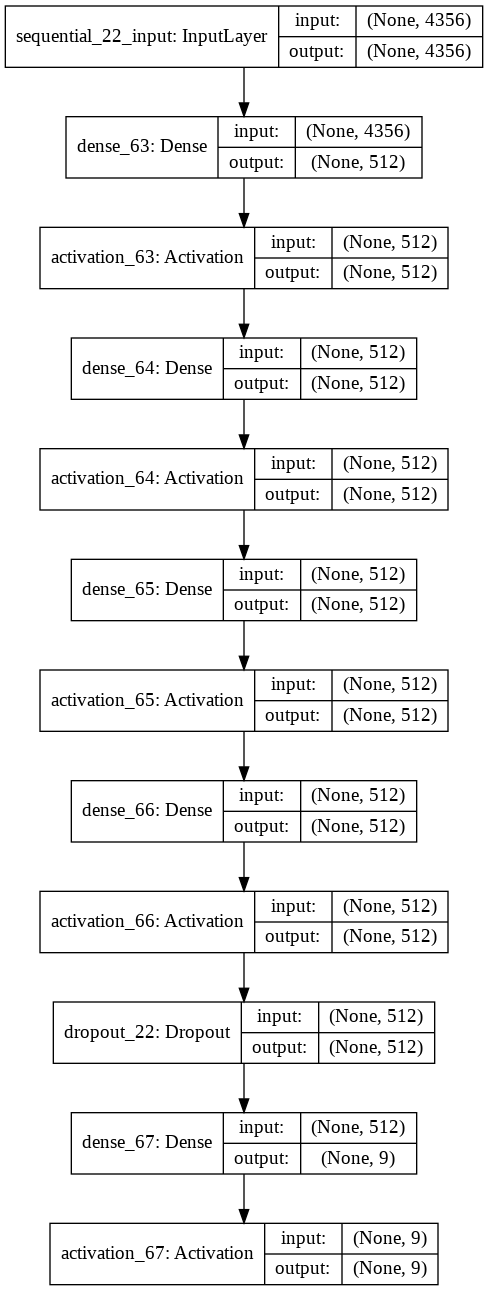

In [0]:
plot_model(model, to_file='model_plot.png', rankdir="TB",show_shapes=True, show_layer_names=True)

# **Train Confusion Matrixes**

In [0]:
trainY.shape

(2610, 9)

In [0]:
testY.shape

(543, 9)

In [0]:
trainX.shape

(2610, 4356)

In [0]:
testX.shape

(543, 4356)

In [0]:
predicted=model.predict(trainX)
pred_y=lb.inverse_transform(predicted)

In [0]:
train_y=lb.inverse_transform(trainY)
train_y[3]

'Batteries'

In [0]:
pred_y[3]

'Batteries'

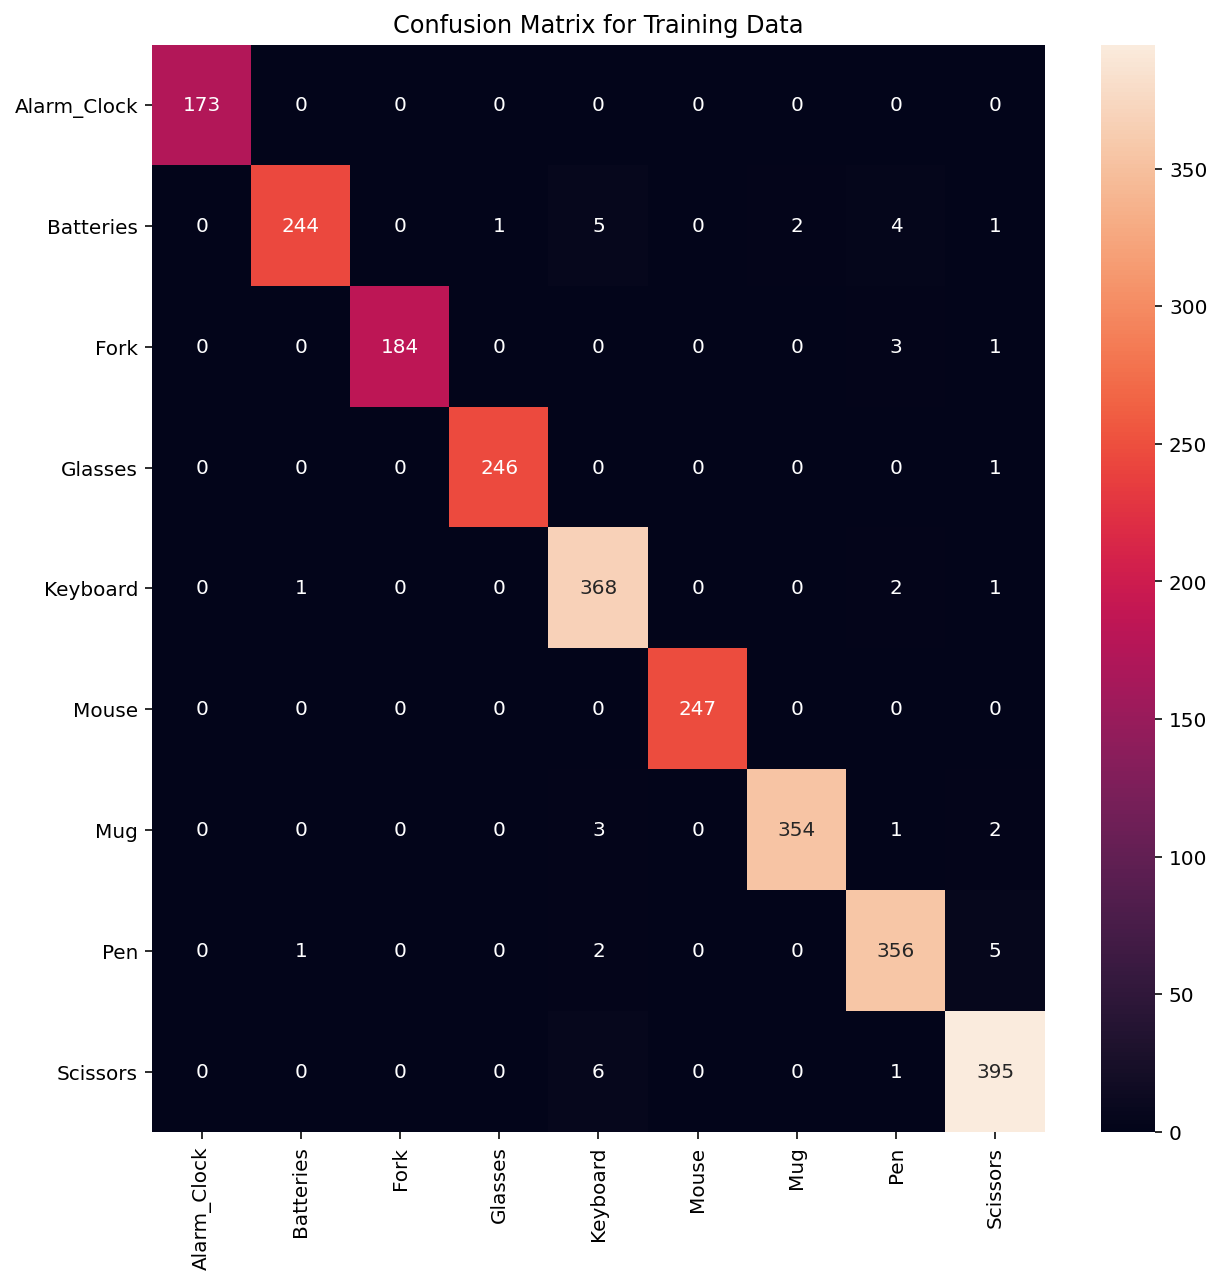

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.metrics import confusion_matrix
import seaborn as sns

classify=['Alarm_Clock','Batteries','Fork','Glasses','Keyboard','Mouse','Mug','Pen','Scissors']

cm=confusion_matrix(train_y,pred_y)
plt.figure(figsize=(10,10))
plt.title("Confusion Matrix for Training Data")
sns.heatmap(cm, annot=True,fmt='d', xticklabels=classify, yticklabels=classify)

# **Validation Confusion Matrixes**

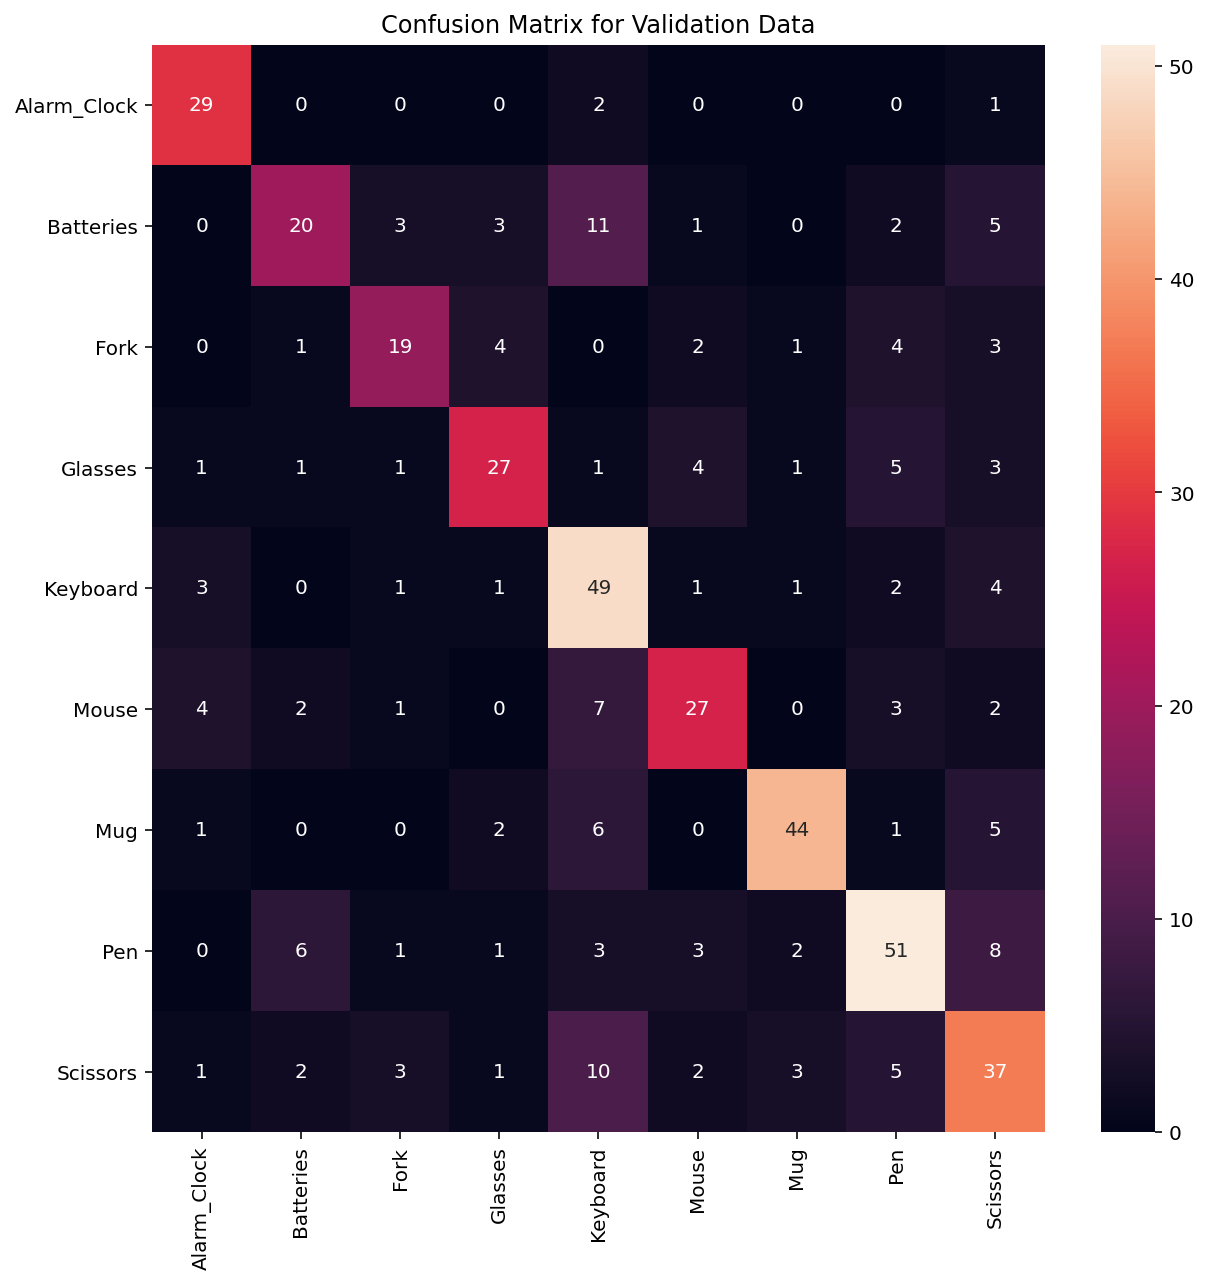

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted=model.predict(validationX)
pred_y=lb.inverse_transform(predicted)
validation_y=lb.inverse_transform(validationY)
classify=['Alarm_Clock','Batteries','Fork','Glasses','Keyboard','Mouse','Mug','Pen','Scissors']
cm=confusion_matrix(validation_y,pred_y)
plt.figure(figsize=(10,10))
plt.title("Confusion Matrix for Validation Data")
sns.heatmap(cm, annot=True,fmt='d', xticklabels=classify, yticklabels=classify)

# **Test Confusion Matrixes**

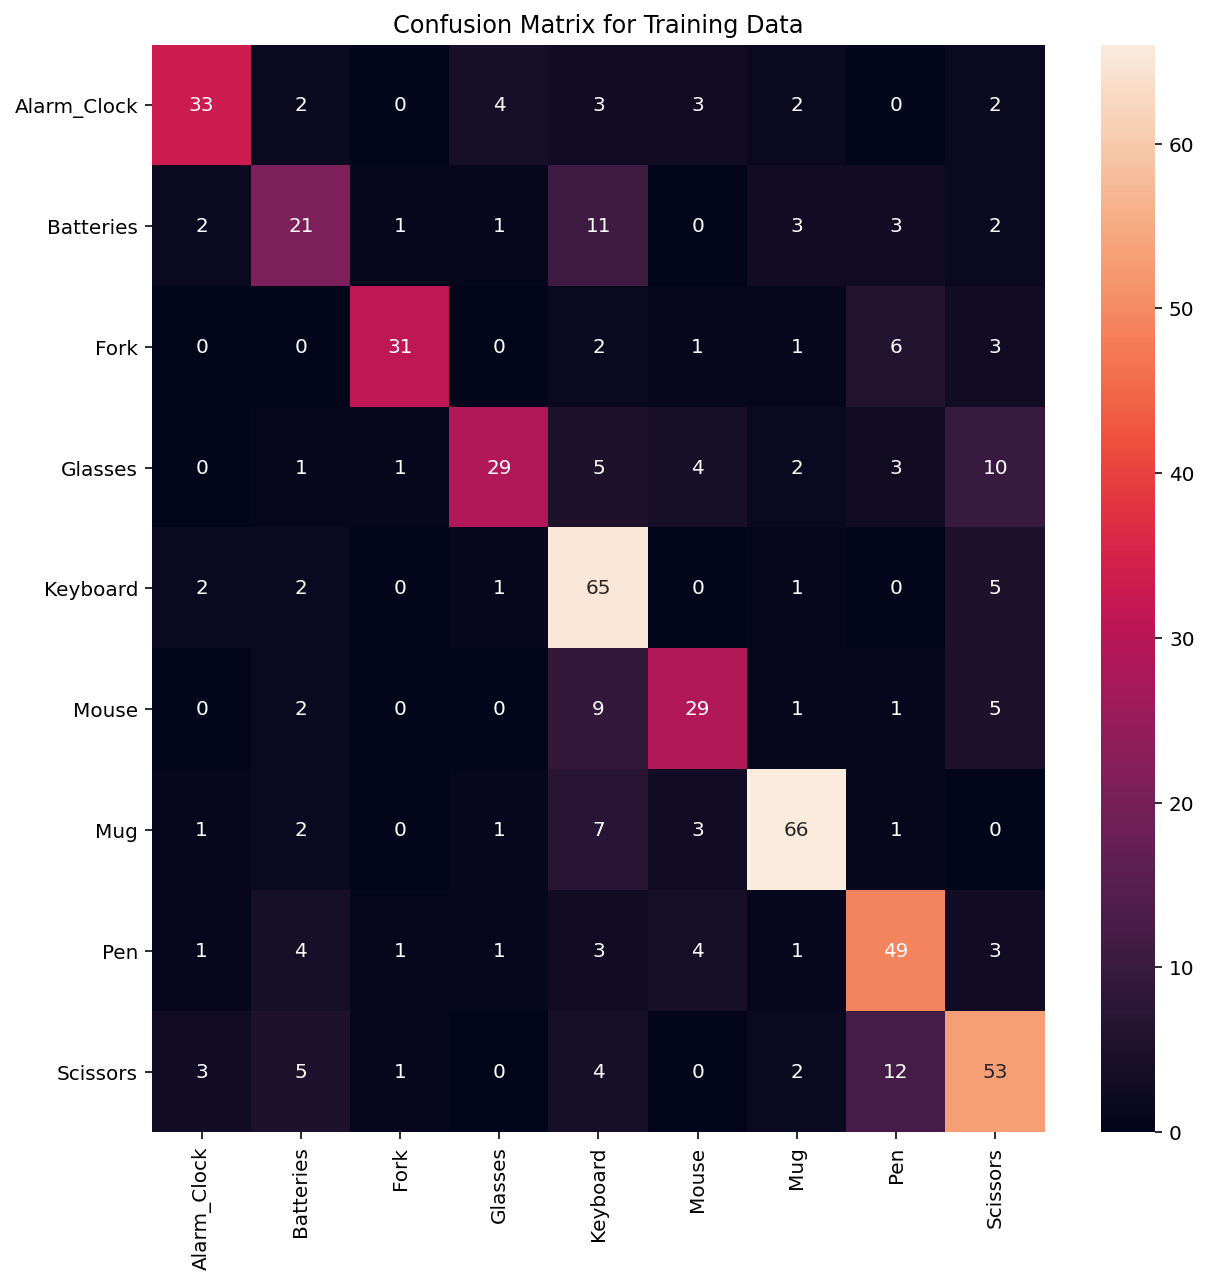

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted=model.predict(testX)
pred_y=lb.inverse_transform(predicted)
test_y=lb.inverse_transform(testY)

classify=['Alarm_Clock','Batteries','Fork','Glasses','Keyboard','Mouse','Mug','Pen','Scissors']
cm=confusion_matrix(test_y,pred_y)
plt.figure(figsize=(10,10))
plt.title("Confusion Matrix for Test Data")
sns.heatmap(cm, annot=True,fmt='d', xticklabels=classify, yticklabels=classify)

In [0]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 512)               2230784   
_________________________________________________________________
activation_63 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_64 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_65 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 512)             